### Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Enhancing the Dataset With CLAHE

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage import img_as_float

In [ ]:
class CLAHEEnhancer:
    def __init__(self, input_dir, output_dir, hist_dir, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.hist_dir = hist_dir
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.hist_dir, exist_ok=True)

    def process_image(self, filename):
        # Load image
        image_path = os.path.join(self.input_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error: Image {filename} could not be read.")
            return

        image = img_as_float(image)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        clahe_image = clahe.apply((image * 255).astype(np.uint8))

        # Save the CLAHE-enhanced image
        output_path = os.path.join(self.output_dir, filename)
        cv2.imwrite(output_path, clahe_image)


    def run(self):
        # Iterate over images in the input directory
        for filename in os.listdir(self.input_dir):
            if filename.endswith((".png", ".jpg", ".jpeg")):
                self.process_image(filename)

# Usage example
input_dir = '/content/drive/Shared drives/Image Processing Assignment/images'
output_dir = '/content/drive/Shared drives/Image Processing Assignment/CLAHEImages'
hist_dir = '/content/drive/Shared drives/Image Processing Assignment/CLAHEHistograms'

enhancer = CLAHEEnhancer(input_dir, output_dir, hist_dir, clip_limit=2.0, tile_grid_size=(8, 8))
enhancer.run()


### Install the Necessary Packages

In [ ]:
pip install numpy pandas matplotlib tensorflow keras scikit-learn opencv-python


## Performance of Machine Learning Techniques on Original Dataset

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Set directories
train_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/training/fractured'
train_not_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/training/not_fractured'
test_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured'
test_not_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/not_fractured'
image_size = (64, 64)  # Resize images to 64x64 for simplicity

# Function to load and preprocess images
def load_images_from_folder(folder, label):
    data = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize image
            img_flattened = img.flatten()  # Flatten to a 1D array
            data.append((img_flattened, label))
    return data

# Load fractured and not fractured images
fractured_images = load_images_from_folder(train_fractured_dir, label=1)
not_fractured_images = load_images_from_folder(train_not_fractured_dir, label=0)
fractured_test_images = load_images_from_folder(test_fractured_dir, label=1)
not_fractured_test_images = load_images_from_folder(test_not_fractured_dir, label=0)

# Combine data and separate features and labels
train_data = fractured_images + not_fractured_images
test_data = fractured_test_images + not_fractured_test_images
X_train = np.array([x[0] for x in train_data])  # Features
y_train = np.array([x[1] for x in train_data])  # Labels
X_test = np.array([x[0] for x in test_data])  # Features
y_test = np.array([x[1] for x in test_data])  # Labels


### Logistic Regression

In [ ]:
# Create and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predict on the test data
y_pred = log_reg.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fractured", "Fractured"]))


Logistic Regression Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.58      0.72      0.65       240
    Fractured       0.78      0.66      0.71       360

     accuracy                           0.68       600
    macro avg       0.68      0.69      0.68       600
 weighted avg       0.70      0.68      0.69       600



In [ ]:
def predict_fracture(img_path, model, image_size=(64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, image_size)
        img_flattened = img.flatten().reshape(1, -1)  # Reshape for prediction
        prediction = model.predict(img_flattened)
        return "Fractured" if prediction[0] == 1 else "Not Fractured"
    else:
        return "Image not loaded"

# Example usage
result = predict_fracture('/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/not_fractured/1-rotated1-rotated2-rotated2-rotated1.jpg', log_reg)
result1 = predict_fracture('/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured/1-rotated1-rotated1-rotated3.jpg', log_reg)
print(result)
print(result1)


Not Fractured
Fractured


### Convolution Neural Network(CNN)

In [ ]:
# using cnn

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score

# Set directories (same as in your example)
train_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/training/fractured'
train_not_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/training/not_fractured'
test_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured'
test_not_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/not_fractured'
image_size = (64, 64)  # Resize images to 64x64
batch_size = 32

# Function to load and preprocess images
def load_images_from_folder(folder, label):
    data = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize
            img = img / 255.0  # Normalize to [0, 1]
            img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
            data.append((img, label))
    return data

# Load fractured and not fractured images for both training and testing sets
train_data = load_images_from_folder(train_fractured_dir, 1) + load_images_from_folder(train_not_fractured_dir, 0)
test_data = load_images_from_folder(test_fractured_dir, 1) + load_images_from_folder(test_not_fractured_dir, 0)

# Shuffle the data
np.random.shuffle(train_data)
np.random.shuffle(test_data)

# Separate features and labels for train and test sets
X_train = np.array([x[0] for x in train_data])
y_train = np.array([x[1] for x in train_data])
X_test = np.array([x[0] for x in test_data])
y_test = np.array([x[1] for x in test_data])

# Reshape the data if necessary (add a channel dimension for grayscale images)
X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fractured", "Fractured"]))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 75s 262ms/step - accuracy: 0.6458 - loss: 0.6267 - val_accuracy: 0.6183 - val_loss: 0.6005
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 67s 241ms/step - accuracy: 0.8557 - loss: 0.3268 - val_accuracy: 0.6900 - val_loss: 0.5390
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 83s 245ms/step - accuracy: 0.9547 - loss: 0.1259 - val_accuracy: 0.7517 - val_loss: 0.4514
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 82s 245ms/step - accuracy: 0.9763 - loss: 0.0739 - val_accuracy: 0.7083 - val_loss: 0.6078
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 71s 256ms/step - accuracy: 0.9894 - loss: 0.0355 - val_accuracy: 0.6750 - val_loss: 0.8817
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 78s 244ms/step - accuracy: 0.9896 - loss: 0.0370 - val_accuracy: 0.7083 - val_loss: 0.7010
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 79s 233ms/step - accuracy: 0.9925 - loss: 0.0225 - val_accuracy: 0.7183 - val_loss: 0.8644
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.9940 - loss: 0

In [ ]:
def predict_single_image(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, image_size)  # Resize to match the training size
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    if prediction > 0.5:
        print("The X-ray image shows a fracture.")
    else:
        print("The X-ray image does not show a fracture.")

    return prediction[0][0]

image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/not_fractured/1-rotated1-rotated2-rotated2-rotated1.jpg'
prediction_score = predict_single_image(image_path, model)
print(f"Prediction Score: {prediction_score}")

image_path2 = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured/1-rotated1-rotated1-rotated3.jpg'
prediction_score2 = predict_single_image(image_path2, model)
print(f"Prediction Score: {prediction_score2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
The X-ray image does not show a fracture.
Prediction Score: 0.002528158714994788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The X-ray image does not show a fracture.
Prediction Score: 0.3211310803890228


In [ ]:
# Combine data and separate features and labels
train_data = fractured_images + not_fractured_images
test_data = fractured_test_images + not_fractured_test_images
X_train = np.array([x[0] for x in train_data])  # Features
y_train = np.array([x[1] for x in train_data])  # Labels
X_test = np.array([x[0] for x in test_data])  # Features
y_test = np.array([x[1] for x in test_data])  # Labels

## K-Nearest Neighbors(KNN)

In [ ]:
#KNN

from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune 'n_neighbors'

# Train the model
knn.fit(X_train, y_train)

# Predict on the test data
y_pred_knn = knn.predict(X_test)

# Calculate accuracy and print classification report
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Accuracy: {accuracy_knn:.2f}')
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=["Not Fractured", "Fractured"]))



K-Nearest Neighbors Accuracy: 0.76
KNN Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.64      0.91      0.75       240
    Fractured       0.92      0.66      0.77       360

     accuracy                           0.76       600
    macro avg       0.78      0.79      0.76       600
 weighted avg       0.81      0.76      0.76       600



### Random Forest Classifiers

In [ ]:
# Randomforest

from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tune 'n_estimators'

# Train the model
rf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf.predict(X_test)

# Calculate accuracy and print classification report
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Not Fractured", "Fractured"]))


Random Forest Accuracy: 0.61
Random Forest Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.51      0.76      0.61       240
    Fractured       0.76      0.51      0.61       360

     accuracy                           0.61       600
    macro avg       0.64      0.64      0.61       600
 weighted avg       0.66      0.61      0.61       600



### Support Vector Classification(SVC)

In [ ]:
# SVM

from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC(kernel='linear', probability=True, random_state=42)  # 'linear' kernel; you can try 'rbf'

# Train the model
svm.fit(X_train, y_train)

# Predict on the test data
y_pred_svm = svm.predict(X_test)

# Calculate accuracy and print classification report
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["Not Fractured", "Fractured"]))


Support Vector Machine Accuracy: 0.68
SVM Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.58      0.76      0.66       240
    Fractured       0.80      0.63      0.70       360

     accuracy                           0.68       600
    macro avg       0.69      0.70      0.68       600
 weighted avg       0.71      0.68      0.68       600



### Decision Tree Classificaton

In [ ]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)  # You can tune 'max_depth', 'min_samples_split', etc.

# Train the model
dt.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt.predict(X_test)

# Calculate accuracy and print classification report
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=["Not Fractured", "Fractured"]))


Decision Tree Accuracy: 0.69
Decision Tree Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.63      0.52      0.57       240
    Fractured       0.71      0.80      0.75       360

     accuracy                           0.69       600
    macro avg       0.67      0.66      0.66       600
 weighted avg       0.68      0.69      0.68       600



### Comparison Analysis

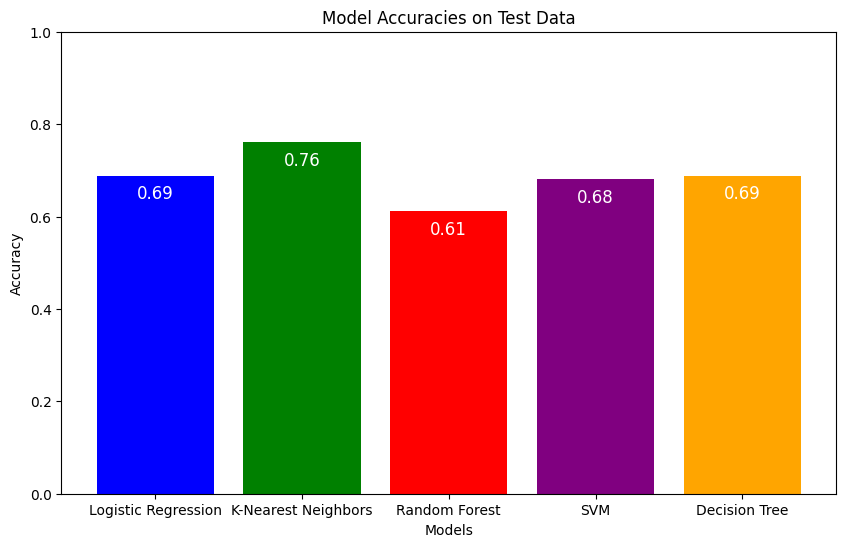

In [ ]:
#Plot graph

import matplotlib.pyplot as plt

# Define models and their accuracies
models = ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest', 'SVM', 'Decision Tree']
accuracies = [accuracy_log, accuracy_knn, accuracy_rf, accuracy_svm, accuracy_dt]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylim([0, 1])
plt.title('Model Accuracies on Test Data')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{acc:.2f}', ha='center', color='white', fontsize=12)

plt.show()



# Machine Learning Techniques On Enhanced Image Dataset



In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Set directories
train_fractured_dir = '/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/training/fractured'
train_not_fractured_dir = '/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/training/not_fractured'
test_fractured_dir = '/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured'
test_not_fractured_dir = '/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/not_fractured'
image_size = (64, 64)  # Resize images to 64x64 for simplicity

# Function to load and preprocess images
def load_images_from_folder(folder, label):
    data = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize image
            img_flattened = img.flatten()  # Flatten to a 1D array
            data.append((img_flattened, label))
    return data

# Load fractured and not fractured images
fractured_images = load_images_from_folder(train_fractured_dir, label=1)
not_fractured_images = load_images_from_folder(train_not_fractured_dir, label=0)
fractured_test_images = load_images_from_folder(test_fractured_dir, label=1)
not_fractured_test_images = load_images_from_folder(test_not_fractured_dir, label=0)


In [ ]:
# Combine data and separate features and labels
train_data = fractured_images + not_fractured_images
test_data = fractured_test_images + not_fractured_test_images
X_train = np.array([x[0] for x in train_data])  # Features
y_train = np.array([x[1] for x in train_data])  # Labels
X_test = np.array([x[0] for x in test_data])  # Features
y_test = np.array([x[1] for x in test_data])  # Labels

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune 'n_neighbors'

# Train the model
knn.fit(X_train, y_train)

# Predict on the test data
y_pred_knn = knn.predict(X_test)

# Calculate accuracy and print classification report
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Accuracy: {accuracy_knn:.2f}')
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=["Not Fractured", "Fractured"]))


K-Nearest Neighbors Accuracy: 0.74
KNN Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.62      0.88      0.73       240
    Fractured       0.89      0.64      0.75       360

     accuracy                           0.74       600
    macro avg       0.75      0.76      0.74       600
 weighted avg       0.78      0.74      0.74       600



Optional Hyperparameter Tuning for *KNN*

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 21)}  # Testing k from 1 to 20

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search_knn.fit(X_train, y_train)

# Best parameters and score
print(f'Best K for KNN: {grid_search_knn.best_params_["n_neighbors"]}')
print(f'Best KNN Cross-Validation Accuracy: {grid_search_knn.best_score_:.2f}')

# Predict with the best estimator
y_pred_knn_best = grid_search_knn.best_estimator_.predict(X_test)
accuracy_knn_best = accuracy_score(y_test, y_pred_knn_best)
print(f'Optimized KNN Accuracy: {accuracy_knn_best:.2f}')
print("Optimized KNN Classification Report:")
print(classification_report(y_test, y_pred_knn_best, target_names=["Not Fractured", "Fractured"]))


Best K for KNN: 1
Best KNN Cross-Validation Accuracy: 0.74
Optimized KNN Accuracy: 0.76
Optimized KNN Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.65      0.89      0.75       240
    Fractured       0.90      0.68      0.77       360

     accuracy                           0.76       600
    macro avg       0.77      0.78      0.76       600
 weighted avg       0.80      0.76      0.76       600



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tune 'n_estimators'

# Train the model
rf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf.predict(X_test)

# Calculate accuracy and print classification report
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Not Fractured", "Fractured"]))


Random Forest Accuracy: 0.69
Random Forest Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.58      0.78      0.67       240
    Fractured       0.81      0.63      0.71       360

     accuracy                           0.69       600
    macro avg       0.70      0.71      0.69       600
 weighted avg       0.72      0.69      0.69       600



### Support Vector Classification

In [ ]:
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC(kernel='linear', probability=True, random_state=42)  # 'linear' kernel; you can try 'rbf'

# Train the model
svm.fit(X_train, y_train)

# Predict on the test data
y_pred_svm = svm.predict(X_test)

# Calculate accuracy and print classification report
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["Not Fractured", "Fractured"]))


Support Vector Machine Accuracy: 0.62
SVM Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.52      0.68      0.59       240
    Fractured       0.73      0.59      0.65       360

     accuracy                           0.62       600
    macro avg       0.63      0.63      0.62       600
 weighted avg       0.65      0.62      0.63       600



### Decision Tree Classifier


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)  # You can tune 'max_depth', 'min_samples_split', etc.

# Train the model
dt.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt.predict(X_test)

# Calculate accuracy and print classification report
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=["Not Fractured", "Fractured"]))


Decision Tree Accuracy: 0.79
Decision Tree Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.71      0.80      0.75       240
    Fractured       0.86      0.78      0.82       360

     accuracy                           0.79       600
    macro avg       0.78      0.79      0.78       600
 weighted avg       0.80      0.79      0.79       600



### Logistic Regression

In [ ]:
# Create and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predict on the test data
y_pred = log_reg.predict(X_test)

# Calculate accuracy and print classification report
accuracy_log = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy_log:.2f}')
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fractured", "Fractured"]))


Logistic Regression Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.50      0.59      0.54       240
    Fractured       0.69      0.61      0.64       360

     accuracy                           0.60       600
    macro avg       0.59      0.60      0.59       600
 weighted avg       0.61      0.60      0.60       600



In [ ]:
def predict_fracture(img_path, model, image_size=(64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, image_size)
        img_flattened = img.flatten().reshape(1, -1)  # Reshape for prediction
        prediction = model.predict(img_flattened)
        return "Fractured" if prediction[0] == 1 else "Not Fractured"
    else:
        return "Image not loaded"

# Example usage
result = predict_fracture('/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/not_fractured/1-rotated1-rotated2-rotated2-rotated1.jpg', log_reg)
result1 = predict_fracture('/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured/1-rotated1-rotated1-rotated3.jpg', log_reg)
print(result)
print(result1)


Not Fractured
Fractured


## Plot Graph

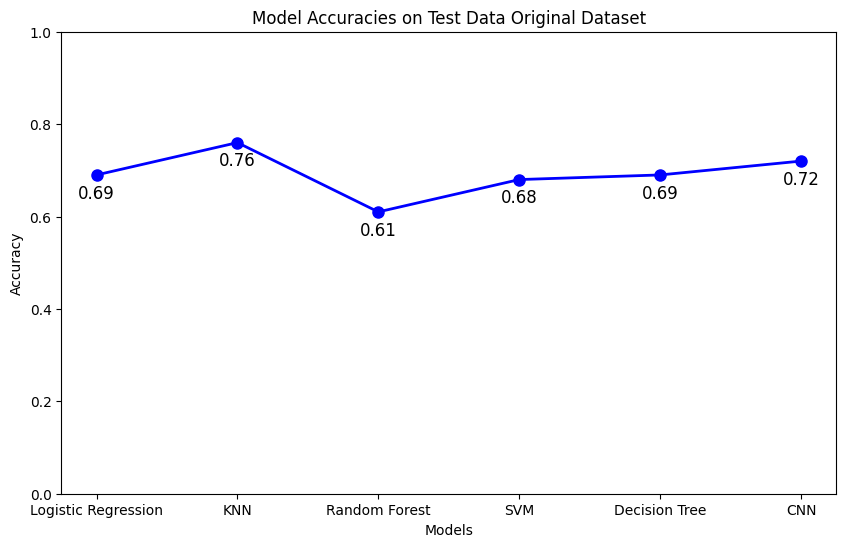

In [ ]:
import matplotlib.pyplot as plt

# Define models and their accuracies
models = ['Logistic Regression', 'KNN', 'Random Forest', 'SVM', 'Decision Tree','CNN']
accuracies = [0.69, 0.76, 0.61, 0.68, 0.69,0.72]

# Plotting the accuracies as a line plot with dots
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.ylim([0, 1])
plt.title('Model Accuracies on Test Data Original Dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Annotate dots with accuracy values
for model, acc in zip(models, accuracies):
    plt.text(model, acc - 0.05, f'{acc:.2f}', ha='center', color='black', fontsize=12)

plt.show()


### Convolution Neural Network

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fractured", "Fractured"]))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 74s 258ms/step - accuracy: 0.6227 - loss: 0.6356 - val_accuracy: 0.7383 - val_loss: 0.5115
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 75s 234ms/step - accuracy: 0.8354 - loss: 0.3706 - val_accuracy: 0.7167 - val_loss: 0.6980
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 64s 233ms/step - accuracy: 0.9419 - loss: 0.1523 - val_accuracy: 0.7300 - val_loss: 0.7197
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - accuracy: 0.9725 - loss: 0.0803 - val_accuracy: 0.6700 - val_loss: 1.0756
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 84s 248ms/step - accuracy: 0.9848 - loss: 0.0443 - val_accuracy: 0.6717 - val_loss: 1.0249
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 79s 237ms/step - accuracy: 0.9859 - loss: 0.0365 - val_accuracy: 0.6500 - val_loss: 1.0843
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - accuracy: 0.9901 - loss: 0.0316 - val_accuracy: 0.7100 - val_loss: 1.3987
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 66s 239ms/step - accuracy: 0.9886 - loss: 0

In [ ]:
def predict_single_image(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, image_size)  # Resize to match the training size
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    if prediction > 0.5:
        print("The X-ray image shows a fracture.")
    else:
        print("The X-ray image does not show a fracture.")

    return prediction[0][0]

image_path = '/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/not_fractured/1-rotated1-rotated2-rotated2-rotated1.jpg'
prediction_score = predict_single_image(image_path, model)
print(f"Prediction Score: {prediction_score}")

image_path2 = '/content/drive/Shared drives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured/1-rotated1-rotated1-rotated3.jpg'
prediction_score2 = predict_single_image(image_path2, model)
print(f"Prediction Score: {prediction_score2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The X-ray image does not show a fracture.
Prediction Score: 0.0005836683558300138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The X-ray image shows a fracture.
Prediction Score: 0.5993458032608032


In [ ]:
#

import cv2
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

# Paths to your dataset (update these paths accordingly)
fractured_image_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/training/fractured'
not_fractured_image_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/training/not_fractured'

# Preprocess an image: load, convert to grayscale, resize, and flatten
def preprocess_image(img_path, image_size=(64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size)
    return img.flatten()  # Flatten the image to a 1D array

# Load images and labels from directories
def load_dataset(fractured_dir, not_fractured_dir):
    X, y = [], []
    for img_name in os.listdir(fractured_dir):
        img_path = os.path.join(fractured_dir, img_name)
        X.append(preprocess_image(img_path))
        y.append(1)  # Label 1 for fractured
    for img_name in os.listdir(not_fractured_dir):
        img_path = os.path.join(not_fractured_dir, img_name)
        X.append(preprocess_image(img_path))
        y.append(0)  # Label 0 for not fractured
    return np.array(X), np.array(y)

# Load and split the dataset
X, y = load_dataset(fractured_image_dir, not_fractured_image_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Decision Tree Accuracy: {accuracy:.2f}')

# Define a prediction function for new images
def predict_fracture(img_path, model, image_size=(64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, image_size)
        img_flattened = img.flatten().reshape(1, -1)  # Reshape for prediction
        prediction = model.predict(img_flattened)
        return "Fractured" if prediction[0] == 1 else "Not Fractured"
    else:
        return "Image not loaded"

# Example prediction
test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/training/fractured/121-rotated1-rotated1-rotated1.jpg'  # Update this path to an actual test image
result = predict_fracture(test_image_path, dt)
print(f'Test Image Prediction: {result}')


Decision Tree Accuracy: 0.96
Test Image Prediction: Fractured


In [ ]:
# Path to another test image
First_test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/ImageForTesing/121.jpg'  # Update with your path

# Predict on the second image
result2 = predict_fracture(First_test_image_path, dt)
print(f'Test Image Prediction: {result2}')


Test Image Prediction: Fractured


In [ ]:
# Path to another test image
second_test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/ImageForTesing/69.jpg'  # Update with your path

# Predict on the second image
result2 = predict_fracture(second_test_image_path, dt)
print(f'Test Image Prediction: {result2}')


Test Image Prediction: Not Fractured


In [ ]:
# For Failure Case

# Path to another test image
test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/ImageForTesing/failurecase.jpg'  # Update with your path

# Predict on the second image
result2 = predict_fracture(test_image_path, dt)
print(f'Test Image Prediction: {result2}')


Test Image Prediction: Not Fractured


In [ ]:
# Using CLAHE

# For Failure Case

# Path to another test image
test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/ImageForTesing/69_clahe.jpg'  # Update with your path

# Predict on the second image
result2 = predict_fracture(test_image_path, dt)
print(f'Test Image Prediction: {result2}')


Test Image Prediction: Not Fractured


In [ ]:
# Using CLAHE

# For Failure Case

# Path to another test image
test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/ImageForTesing/121_clahe.jpg'  # Update with your path

# Predict on the second image
result2 = predict_fracture(test_image_path, dt)
print(f'Test Image Prediction: {result2}')


Test Image Prediction: Fractured


In [ ]:
# Using CLAHE

# For Failure Case

# Path to another test image
test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/ImageForTesing/failurecase_clahe.jpg'  # Update with your path

# Predict on the second image
result2 = predict_fracture(test_image_path, dt)
print(f'Test Image Prediction: {result2}')


Test Image Prediction: Not Fractured


In [ ]:
# Using CLAHE

# For Failure Case

# Path to another test image
test_image_path = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/ImageForTesing/1_fail.jpg'  # Update with your path

# Predict on the second image
result2 = predict_fracture(test_image_path, dt)
print(f'Test Image Prediction: {result2}')


Test Image Prediction: Not Fractured


In [ ]:
# Directories for test images
test_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured'
test_not_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/not_fractured'

# Lists to store incorrectly classified images and their details
failed_images = []

# Function to test each image and log failed cases
def test_images(model, fractured_dir, not_fractured_dir, image_size=(64, 64)):
    for img_name in os.listdir(fractured_dir):
        img_path = os.path.join(fractured_dir, img_name)
        prediction = predict_fracture(img_path, model, image_size)
        true_label = 1  # Fractured
        predicted_label = 1 if prediction == "Fractured" else 0
        if predicted_label != true_label:
            failed_images.append((img_path, "Fractured"))

    for img_name in os.listdir(not_fractured_dir):
        img_path = os.path.join(not_fractured_dir, img_name)
        prediction = predict_fracture(img_path, model, image_size)
        true_label = 0  # Not Fractured
        predicted_label = 1 if prediction == "Fractured" else 0
        if predicted_label != true_label:
            failed_images.append((img_path, "Not Fractured"))

# Run the test and log failed images
test_images(dt, test_fractured_dir, test_not_fractured_dir)

# Print out the failed images and their expected labels
if failed_images:
    print("Misclassified Images:")
    for img_path, true_label in failed_images:
        print(f"Image: {img_path}, Expected: {true_label}, Predicted: {'Fractured' if true_label == 'Not Fractured' else 'Not Fractured'}")
else:
    print("All images classified correctly!")


Misclassified Images:
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured/1-rotated3-rotated1-rotated2.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured/1-rotated2.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured/1-rotated3-rotated3-rotated2.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured/1-rotated2-rotated1-rotated1.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/dataset/Bone Fracture Dataset/testing/fractured/2-rotated1-rotated2-rotated3.jpg, Expected: Fractured, P

In [ ]:
# Directories for test images
test_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured'
test_not_fractured_dir = '/content/drive/Shareddrives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/not_fractured'

# Lists to store incorrectly classified images and their details
failed_images = []

# Function to test each image and log failed cases
def test_images(model, fractured_dir, not_fractured_dir, image_size=(64, 64)):
    for img_name in os.listdir(fractured_dir):
        img_path = os.path.join(fractured_dir, img_name)
        prediction = predict_fracture(img_path, model, image_size)
        true_label = 1  # Fractured
        predicted_label = 1 if prediction == "Fractured" else 0
        if predicted_label != true_label:
            failed_images.append((img_path, "Fractured"))

    for img_name in os.listdir(not_fractured_dir):
        img_path = os.path.join(not_fractured_dir, img_name)
        prediction = predict_fracture(img_path, model, image_size)
        true_label = 0  # Not Fractured
        predicted_label = 1 if prediction == "Fractured" else 0
        if predicted_label != true_label:
            failed_images.append((img_path, "Not Fractured"))

# Run the test and log failed images
test_images(dt, test_fractured_dir, test_not_fractured_dir)

# Print out the failed images and their expected labels
if failed_images:
    print("Misclassified Images:")
    for img_path, true_label in failed_images:
        print(f"Image: {img_path}, Expected: {true_label}, Predicted: {'Fractured' if true_label == 'Not Fractured' else 'Not Fractured'}")
else:
    print("All images classified correctly!")


Misclassified Images:
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured/1-rotated3-rotated1-rotated2.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured/1-rotated3-rotated2-rotated2.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured/1-rotated3-rotated1-rotated3.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Dataset/testing/fractured/1-rotated3-rotated2-rotated3.jpg, Expected: Fractured, Predicted: Not Fractured
Image: /content/drive/Shareddrives/Image Processing Assignment/Assignment 2/CLAHEImages/dataset/Bone Fracture Data